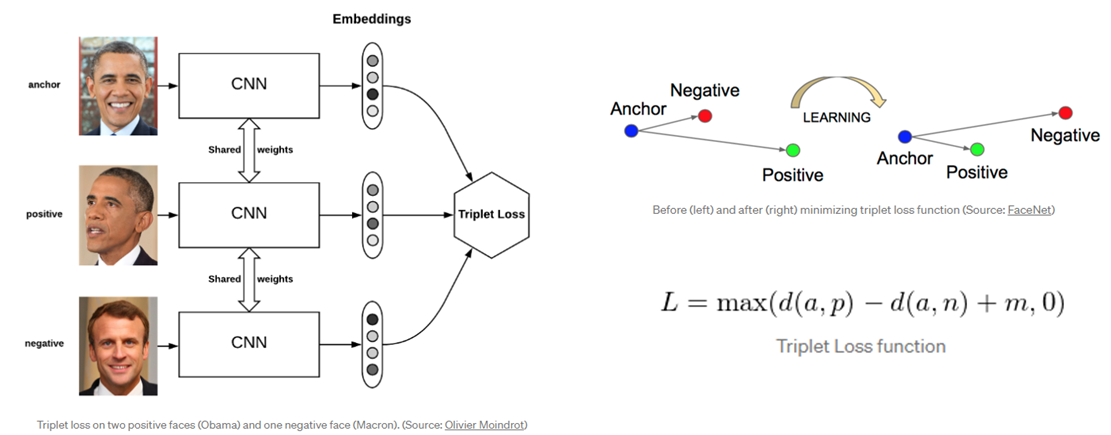

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

from pathlib import Path
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.models as models

target_shape = (150, 150)

In [2]:
cache_dir = "./dataset"
anchor_images_path = cache_dir + "/left/"
positive_images_path = cache_dir + "/right/"

In [3]:
## Data download ##
## left, right 폴더 내에 있는 같은 파일명의 이미지는 positive pair

# https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34 
# https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW 


In [4]:
## Image path list 에 저장
anchor_images = sorted(
    [os.path.join(anchor_images_path, f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [os.path.join(positive_images_path, f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

In [5]:
transform = transforms.Compose([
    transforms.Resize(target_shape),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, anchor_path, positive_path):
        self.anchor_path = anchor_path
        self.positive_path = positive_path

    def __getitem__(self, index):
        anchor = Image.open(self.anchor_path[index % len(self.anchor_path)])
        positive = Image.open(self.positive_path[index % len(self.positive_path)])
        ## 나머지 이미지 중 랜덤하게 뽑은 하나의 이미지를 negative sample 로 함
        negative_path = np.random.choice(self.anchor_path+self.positive_path,1)[0]
        negative = Image.open(negative_path)
        
        if anchor.mode != "RGB":
            anchor = to_rgb(anchor)
        if positive.mode != "RGB":
            positive = to_rgb(positive)
        if negative.mode != "RGB":
            negative = to_rgb(negative)
        
        return transform(anchor), transform(positive), transform(negative)

    def __len__(self):
        return len(self.anchor_path)

In [7]:
train_anchor, valid_anchor, train_positive, valid_positive = train_test_split(anchor_images, positive_images, test_size=0.2, random_state=42)

In [8]:
train_loader = torch.utils.data.DataLoader(ImageDataset(train_anchor, train_positive),
                                         batch_size=32,
                                         shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(ImageDataset(valid_anchor, valid_positive),
                                         batch_size=32,
                                         shuffle=False, drop_last=False)

In [9]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(min(3, len(anchor))):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [11]:
anchor_sample, positive_sample, negative_sample = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


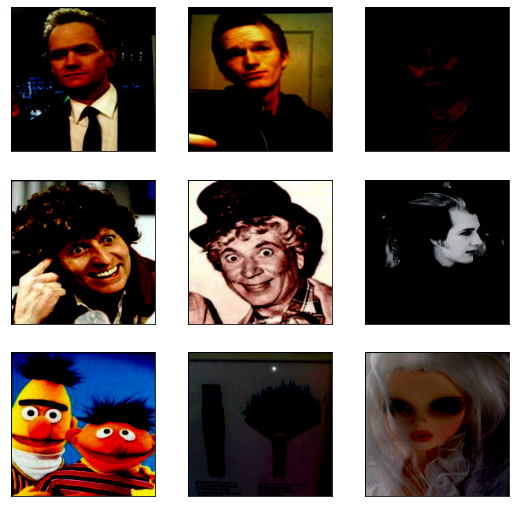

In [61]:
visualize(anchor_sample.permute(0,2,3,1), positive_sample.permute(0,2,3,1), negative_sample.permute(0,2,3,1))

In [10]:
base_cnn = models.resnet50(pretrained=True)
output_layer = nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256,256),
)
base_cnn.fc = output_layer
embedding = base_cnn

In [11]:
trainable = False
embedding.trainable = trainable
## 마지막 일부 레이어만 학습에 사용
embedding.layer4.trainable = True

In [12]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''
margin triplet loss 정의
L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
''' 
def triplet_loss(anchor, positive, negative, margin=0.5) :
    ap_distance = torch.square(anchor - positive)
    an_distance = torch.square(anchor - negative)
    loss = ap_distance - an_distance + margin
    loss = torch.mean(torch.max(loss + margin, torch.tensor(0.0)))
    return loss

optimizer = torch.optim.Adam(embedding.parameters(), lr=1e-4)
embedding = embedding.to(device)
epochs = 10

In [14]:
for epoch in range(epochs) :
    embedding.layer4.trainable = True
    train_loss_tracker = AverageMeter()
    valid_loss_tracker = AverageMeter()
    
    i=0
    for anchor, positive, negative in train_loader:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        anchor_feature = embedding(anchor)
        positive_feature = embedding(positive)
        negative_feature = embedding(negative)
        
        loss = triplet_loss(anchor_feature, positive_feature, negative_feature)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_tracker.update(np.mean(loss.item()))
        
        if i % 30 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'train_loss: {train_loss_tracker.val:.4f} ({train_loss_tracker.avg:.4f})\t'
                  .format(epoch, i, len(train_loader),
                          train_loss_tracker=train_loss_tracker))
        i+=1
    
    embedding.trainable=False
    for anchor, positive, negative in valid_loader:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        anchor_feature = embedding(anchor)
        positive_feature = embedding(positive)
        negative_feature = embedding(negative)
        
        loss = triplet_loss(anchor_feature, positive_feature, negative_feature)
        
        valid_loss_tracker.update(np.mean(loss.item()))
        
    print('Epoch: [{0}]\t\t'
          'valid_loss: {valid_loss_tracker.avg:.4f}\t'
          .format(epoch,
                  valid_loss_tracker=valid_loss_tracker))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0][0/150]	train_loss: 1.0917 (1.0917)	
Epoch: [0][30/150]	train_loss: 0.9882 (1.0168)	
Epoch: [0][60/150]	train_loss: 0.8375 (0.9547)	
Epoch: [0][90/150]	train_loss: 0.7849 (0.9134)	
Epoch: [0][120/150]	train_loss: 0.7370 (0.8842)	
Epoch: [0]		valid_loss: 0.7196	
Epoch: [1][0/150]	train_loss: 0.7164 (0.7164)	
Epoch: [1][30/150]	train_loss: 0.5730 (0.6557)	
Epoch: [1][60/150]	train_loss: 0.7611 (0.6746)	
Epoch: [1][90/150]	train_loss: 0.8951 (0.6919)	
Epoch: [1][120/150]	train_loss: 0.6063 (0.6856)	
Epoch: [1]		valid_loss: 0.7031	
Epoch: [2][0/150]	train_loss: 0.5088 (0.5088)	
Epoch: [2][30/150]	train_loss: 0.4050 (0.5763)	
Epoch: [2][60/150]	train_loss: 0.5664 (0.5965)	
Epoch: [2][90/150]	train_loss: 0.7559 (0.6066)	
Epoch: [2][120/150]	train_loss: 0.5351 (0.6134)	
Epoch: [2]		valid_loss: 0.6698	
Epoch: [3][0/150]	train_loss: 0.5150 (0.5150)	
Epoch: [3][30/150]	train_loss: 0.7279 (0.5479)	
Epoch: [3][60/150]	train_loss: 0.4989 (0.5685)	
Epoch: [3][90/150]	train_loss: 0.4379 (0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


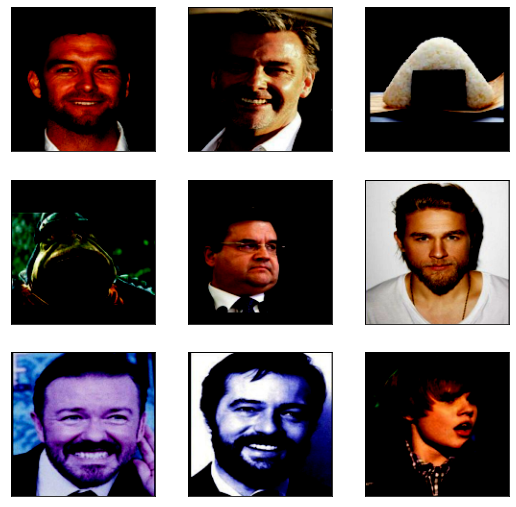

In [15]:
'''
Train batch 하나에 대해 positive similarity 와 negative similarity 확인
'''
sample = next(iter(train_loader))
anchor, positive, negative = sample
embedding = embedding.to('cpu')
visualize(anchor.permute(0,2,3,1), positive.permute(0,2,3,1), negative.permute(0,2,3,1))

# anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

In [21]:
'''
Train batch 하나에 대해 positive similarity 와 negative similarity 확인
'''
cosine_similarity = nn.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", np.mean(positive_similarity.detach().cpu().numpy()))

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", np.mean(negative_similarity.detach().cpu().numpy()))

Positive similarity: 0.7562689
Negative similarity -0.12583454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


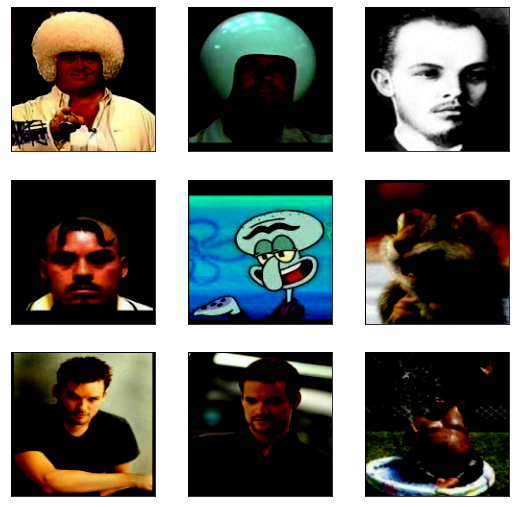

In [110]:
'''
Valid batch 하나에 대해 positive similarity 와 negative similarity 확인
'''
sample = next(iter(valid_loader))
anchor, positive, negative = sample
embedding = embedding.to('cpu')
visualize(anchor.permute(0,2,3,1), positive.permute(0,2,3,1), negative.permute(0,2,3,1))

anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

In [111]:
'''
Valid batch 하나에 대해 positive similarity 와 negative similarity 확인
'''
cosine_similarity = nn.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", np.mean(positive_similarity.detach().numpy()))

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", np.mean(negative_similarity.detach().numpy()))

Positive similarity: 0.7085656
Negative similarity -0.09713128


In [131]:
'''
Valid batch 내 이미지 하나에 대해 가장 가까운 이미지와 가장 먼 이미지 찾기
 - 검색에 사용할 anchor 이미지 지정
'''
feature_sample = anchor_embedding[5]
anchor_sample = anchor[5]
feature_sample = feature_sample.unsqueeze(1)
feature_sample.shape

torch.Size([256, 1])

In [33]:
# torch.save(embedding.state_dict(), "./finetuned_embedding.pth.tar")
# embedding.load_state_dict(torch.load("./finetuned_embedding.pth.tar"))

In [113]:
'''
Valid batch 내 이미지 하나에 대해 가장 가까운 이미지와 가장 먼 이미지 찾기
 - 전체 validset 의 feature embedding 저장
 - anchor, positive 순으로 저장
'''
from tqdm import tqdm_notebook 
embedding = embedding.to(device)
embedding_dict = []
for a, _, _ in tqdm_notebook(valid_loader):
    a = a.to(device)
    a_feature = embedding(a)
    
    embedding_dict.append(a_feature.detach())
for _, p, _ in tqdm_notebook(valid_loader):
    p = p.to(device)
    p_feature = embedding(p)
    
    embedding_dict.append(p_feature.detach())
embedding_dict = torch.cat(embedding_dict, 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/38 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/38 [00:00<?, ?it/s]

In [132]:
'''
Valid batch 내 이미지 하나에 대해 가장 가까운 이미지와 가장 먼 이미지 찾기
 - cosine similarity 가 가장 가까운 3개(검색대상이 되는 이미지 포함), 가장 먼 3개의 이미지 찾기
'''
sim = torch.stack([cosine_similarity(x.unsqueeze(0), feature_sample.to(device).permute(1,0)) for x in embedding_dict])
max_idx, min_idx = torch.topk(sim,3,0).indices, torch.topk(-sim,3,0).indices
print(max_idx, min_idx)
similar_img = [valid_loader.dataset[x%len(valid_loader.dataset)][x//len(valid_loader.dataset)] for x in max_idx]
dissimilar_img = [valid_loader.dataset[x%len(valid_loader.dataset)][x//len(valid_loader.dataset)] for x in min_idx]

tensor([[   5],
        [ 617],
        [1254]], device='cuda:0') tensor([[1112],
        [1233],
        [1600]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


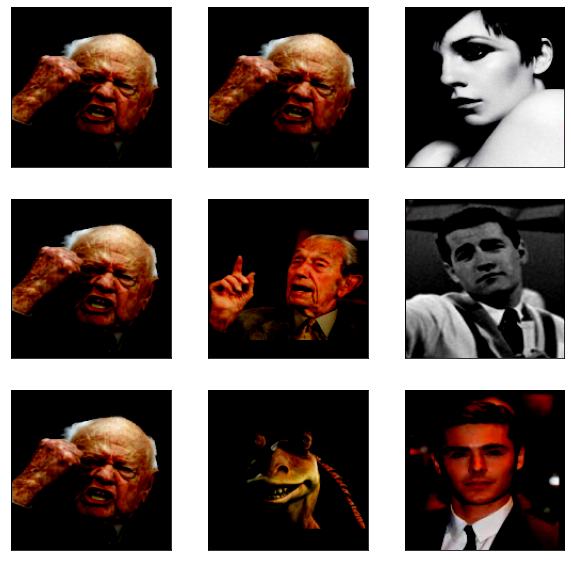

In [133]:
'''
Valid batch 내 이미지 하나에 대해 가장 가까운 이미지와 가장 먼 이미지 찾기
 - 이미지 출력 (anchor, similar, dissimilar)
'''
def show(ax, image):
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(10, 10))

axs = fig.subplots(3, 3)
show(axs[0,0], anchor_sample.to("cpu").permute(1,2,0))
show(axs[0,1], similar_img[0].to("cpu").permute(1,2,0))
show(axs[0,2], dissimilar_img[0].to("cpu").permute(1,2,0))

show(axs[1,0], anchor_sample.to("cpu").permute(1,2,0))
show(axs[1,1], similar_img[1].to("cpu").permute(1,2,0))
show(axs[1,2], dissimilar_img[1].to("cpu").permute(1,2,0))

show(axs[2,0], anchor_sample.to("cpu").permute(1,2,0))
show(axs[2,1], similar_img[2].to("cpu").permute(1,2,0))
show(axs[2,2], dissimilar_img[2].to("cpu").permute(1,2,0))

## Triplet to Contrastive

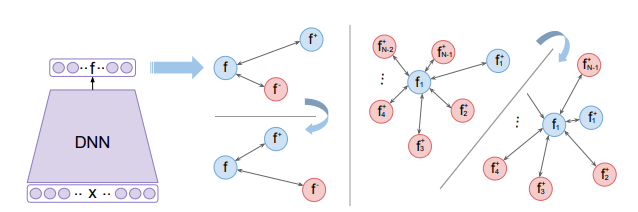

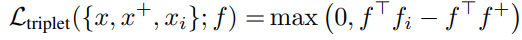

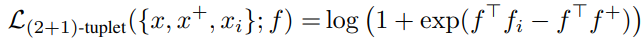

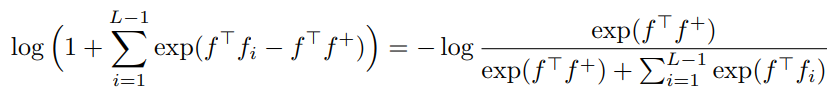